<a href="https://colab.research.google.com/github/eerga/CapstoneMLZoomcamp/blob/main/Food_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Xception model

## Get the data

In [1]:
import kagglehub
import shutil
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

# import the xceptions model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Download to cache (default behavior)
path = kagglehub.dataset_download("erika7/food-101-small-10-categories-trainvaltest-split")

# Copy to your desired location
target_path = "/content/food-101"
shutil.copytree(path, target_path)

print(f"Dataset copied to: {target_path}")

Using Colab cache for faster access to the 'food-101-small-10-categories-trainvaltest-split' dataset.
Dataset copied to: /content/food-101


In [3]:
!rm -rf /root/.cache/kagglehub

In [4]:
def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        # Count common image formats
        images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        total += len(images)
    return total

In [5]:
# Count images in the clothing dataset
total_images = count_images('food-101')
print(f"Total images: {total_images}")

Total images: 3000


In [6]:
train_images = count_images('food-101/train')
print(f"Train images %: {train_images/total_images*100}")

Train images %: 80.0


In [7]:
validation_images = count_images('food-101/validation')
print(f"Total images: {validation_images/total_images*100}")

Total images: 10.0


In [8]:
test_images = count_images('food-101/test')
print(f"Total images: {test_images/total_images*100}")

Total images: 10.0


So, the split is 80% for training, 10% for validation and 10% for testing

In [9]:
dataset_path = 'food-101'

# Collect data for all categories across all splits
category_totals = {}
split_totals = {}
grand_total = 0

splits = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for split in splits:
    split_path = os.path.join(dataset_path, split)
    split_total = 0

    if os.path.exists(split_path):
        categories = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for category in categories:
            category_path = os.path.join(split_path, category)
            image_files = [f for f in os.listdir(category_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
            count = len(image_files)

            # Add to category total
            if category not in category_totals:
                category_totals[category] = {}
            category_totals[category][split] = count

            split_total += count

        split_totals[split] = split_total
        grand_total += split_total

# Display summary
print("SUMMARY BY CATEGORY:")
print("=" * 60)
print(f"{'Category':<15} {'Train':<8} {'Test':<8} {'Val':<8} {'Total':<8}")
print("-" * 60)

for category in sorted(category_totals.keys()):
    train_count = category_totals[category].get('train', 0)
    test_count = category_totals[category].get('test', 0)
    val_count = category_totals[category].get('validation', 0)
    total_count = train_count + test_count + val_count

    print(f"{category.replace('_', ' ').title():<15} {train_count:<8} {test_count:<8} {val_count:<8} {total_count:<8}")

print("-" * 60)
print(f"{'TOTALS':<15} {split_totals.get('train', 0):<8} {split_totals.get('test', 0):<8} {split_totals.get('validation', 0):<8} {grand_total:<8}")

SUMMARY BY CATEGORY:
Category        Train    Test     Val      Total   
------------------------------------------------------------
Chicken Curry   240      30       30       300     
Chocolate Cake  240      30       30       300     
Fish And Chips  240      30       30       300     
Hamburger       240      30       30       300     
Ice Cream       240      30       30       300     
Pad Thai        240      30       30       300     
Pizza           240      30       30       300     
Ramen           240      30       30       300     
Sushi           240      30       30       300     
Tacos           240      30       30       300     
------------------------------------------------------------
TOTALS          2400     300      300      3000    


## Tensorflow and Keras

In [10]:
path = './food-101/train/hamburger'
name = '1010136.jpg'
fullname = f'{path}/{name}'
img1 = load_img(fullname)
print(f"Image size: {img1.size}")  # (width, height)

Image size: (512, 384)


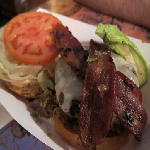

In [11]:
img = load_img(fullname, target_size=(150,150)); img

In [12]:
x = np.array(img)

In [13]:
x.shape

(150, 150, 3)

## Using Pre-trained CNN - [Keras Models](https://keras.io/api/applications/)

In [14]:
# create the model
model = Xception(weights='imagenet', input_shape=(299,299,3))


In [15]:
X = np.array([x])

In [16]:
X = preprocess_input(X)

In [17]:
X.shape

(1, 150, 150, 3)

## Transfer Learning

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

Found 2400 images belonging to 10 classes.


In [19]:
# classes of the traiing data
train_ds.class_indices

{'chicken_curry': 0,
 'chocolate_cake': 1,
 'fish_and_chips': 2,
 'hamburger': 3,
 'ice_cream': 4,
 'pad_thai': 5,
 'pizza': 6,
 'ramen': 7,
 'sushi': 8,
 'tacos': 9}

In [20]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


## Train the model

In [21]:
base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
# making no changes to the convolutional layers
base_model.trainable=False

## Creating a new top (dense layers)
inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [22]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )


In [23]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v0{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [24]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5335 - loss: 1.9902

75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 312ms/step - accuracy: 0.5349 - loss: 1.9848 - val_accuracy: 0.7100 - val_loss: 1.2345
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8350 - loss: 0.5966 - val_accuracy: 0.6700 - val_loss: 1.4814
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8873 - loss: 0.3313

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8872 - loss: 0.3318 - val_accuracy: 0.7500 - val_loss: 1.1589
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9363 - loss: 0.1987 - val_accuracy: 0.6900 - val_loss: 1.6037
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9270 - loss: 0.2150

75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9270 - loss: 0.2148 - val_accuracy: 0.7533 - val_loss: 1.3326
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9780 - loss: 0.0754 - val_accuracy: 0.7300 - val_loss: 1.3446
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9939 - loss: 0.0312 - val_accuracy: 0.7400 - val_loss: 1.4581
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9944 - loss: 0.0278

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9944 - loss: 0.0279 - val_accuracy: 0.7633 - val_loss: 1.3187
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9932 - loss: 0.0245

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9933 - loss: 0.0245 - val_accuracy: 0.7733 - val_loss: 1.3194
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.7567 - val_loss: 1.3552


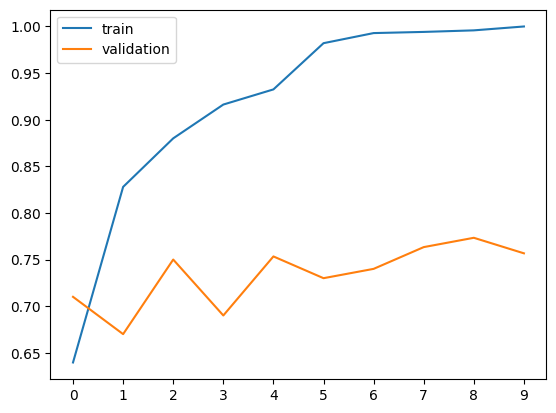

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xticks(np.arange(10))
plt.legend()

The highest validation accuracy is 0.773. Let's see if adjusting learning rate will help improve the situation.

In [26]:
!mkdir images/

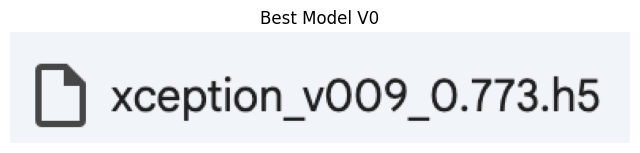

In [28]:
image_path = "./images/best_model_v0.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V0")
plt.show()

## Adjusting Learning Rate

In [29]:
def make_model(learning_rate=0.01):
  base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [30]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [31]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint])
  scores[lr]=history.history

  print()
  print()

0.0001
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1896 - loss: 2.3122

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.1908 - loss: 2.3094 - val_accuracy: 0.4367 - val_loss: 1.7485
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4872 - loss: 1.6227

75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.4879 - loss: 1.6213 - val_accuracy: 0.5800 - val_loss: 1.3734
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6415 - loss: 1.2523

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6417 - loss: 1.2519 - val_accuracy: 0.6233 - val_loss: 1.1853
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6894 - loss: 1.0893

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6895 - loss: 1.0888 - val_accuracy: 0.6500 - val_loss: 1.0728
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7133 - loss: 0.9694

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7135 - loss: 0.9690 - val_accuracy: 0.6600 - val_loss: 1.0047
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7593 - loss: 0.8478

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7592 - loss: 0.8481 - val_accuracy: 0.6767 - val_loss: 0.9595
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7614 - loss: 0.8310

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.7614 - loss: 0.8307 - val_accuracy: 0.6967 - val_loss: 0.9151
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7583 - loss: 0.8003 - val_accuracy: 0.6900 - val_loss: 0.8883
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.7815 - loss: 0.7284 - val_accuracy: 0.6967 - val_loss: 0.8706
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8034 - loss: 0.7032 - val_accuracy: 0.6933 - val_loss: 0.8500


0.001
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4804 - loss: 1.5702

75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.4823 - loss: 1.5650 - val_accuracy: 0.7067 - val_loss: 0.8555
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7834 - loss: 0.6860

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7834 - loss: 0.6857 - val_accuracy: 0.7267 - val_loss: 0.7874
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8194 - loss: 0.5598

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8195 - loss: 0.5596 - val_accuracy: 0.7467 - val_loss: 0.7461
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8714 - loss: 0.4309

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8713 - loss: 0.4312 - val_accuracy: 0.7533 - val_loss: 0.7502
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8915 - loss: 0.3830

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8914 - loss: 0.3831 - val_accuracy: 0.7667 - val_loss: 0.7574
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9181 - loss: 0.3393

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9180 - loss: 0.3394 - val_accuracy: 0.7767 - val_loss: 0.7484
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9354 - loss: 0.2858 - val_accuracy: 0.7700 - val_loss: 0.7501
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9533 - loss: 0.2498 - val_accuracy: 0.7700 - val_loss: 0.7531
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9503 - loss: 0.2236 - val_accuracy: 0.7467 - val_loss: 0.7760
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9608 - loss: 0.1968 - val_accuracy: 0.7700 - val_loss: 0.7512


0.01
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.5606 - loss: 1.8660 - val_accuracy: 0.7167 - val_loss: 1.3525
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8299 - loss: 0.6089 - val_accuracy: 0.7233 - val_loss: 1.2312
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8727 - loss: 0.4119 - val_accuracy: 0.6900 - va

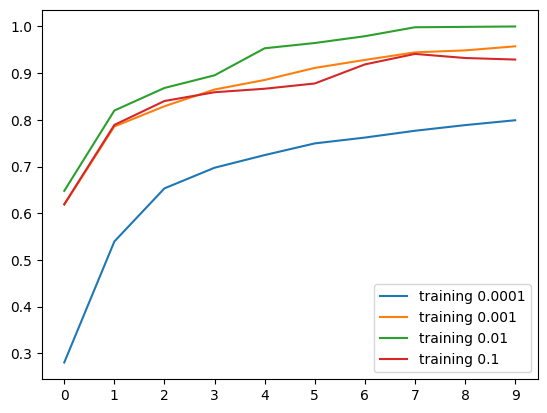

In [32]:
# training lr
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label=f'training {lr}')
plt.xticks(np.arange(10))
plt.legend()

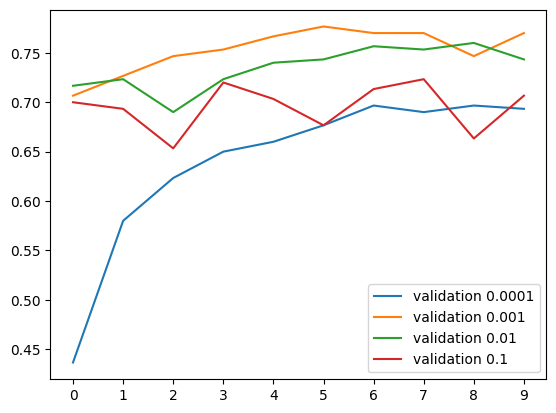

In [33]:
# validation lr
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=f'validation {lr}')
plt.xticks(np.arange(10))
plt.legend()

We are going to drop learning rate 0.1 and 0.0001 because the parameters yielded the lowest validation accuracy results

In [34]:
del scores[0.1]
del scores [0.0001]

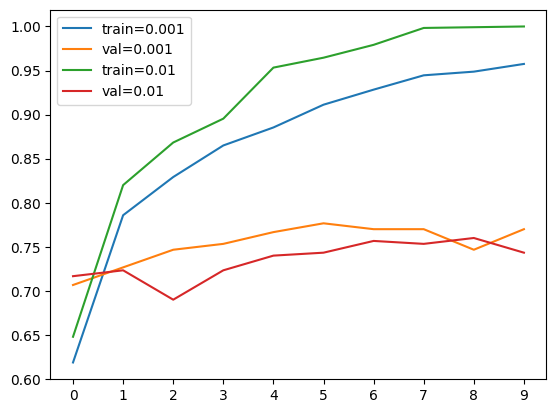

In [35]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

Since the gap between train and validation curves is smaller for lr = 0.001 than for lr = 0.01, we are choosing the learning rate to be 0.001. Also, the validation accuracy for 0.001 is almost always higher than for 0.01 learning rate, so we are going to stick with the learning rate 0.001.

In [36]:
del scores[0.01]

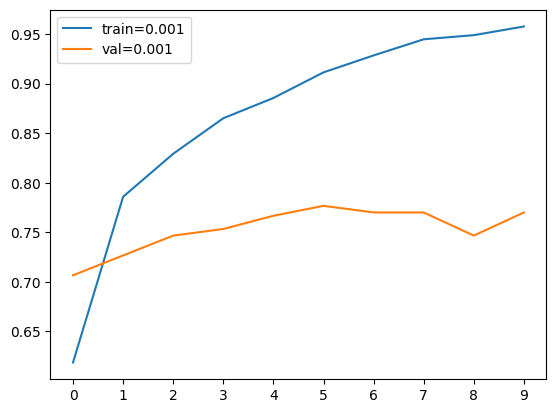

In [37]:
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

You can also notice that the best performing model so far has had the learning rate of 0.001

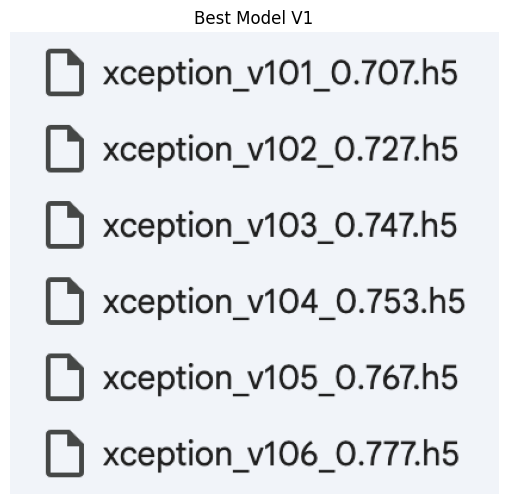

In [41]:
image_path = "./images/best_model_v1.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1")
plt.show()

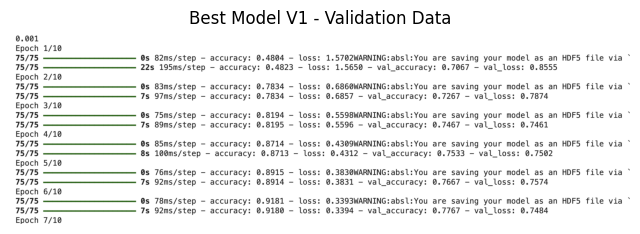

In [42]:
image_path = "./images/best_model_v1_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V1 - Validation Data")
plt.show()

You can see that the 6th epoch is the one that was saved as the best performer.

## Checkpointing - saving the best performing models

At this point, we are simply going to run the best performing model again.

In [43]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [44]:
learning_rate = 0.001
model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint])


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4756 - loss: 1.5576

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.4776 - loss: 1.5521 - val_accuracy: 0.7233 - val_loss: 0.8232
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7915 - loss: 0.6531

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7915 - loss: 0.6531 - val_accuracy: 0.7567 - val_loss: 0.7601
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8210 - loss: 0.5340

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8211 - loss: 0.5341 - val_accuracy: 0.7767 - val_loss: 0.7330
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8642 - loss: 0.4355 - val_accuracy: 0.7733 - val_loss: 0.7662
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8912 - loss: 0.3924

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.8910 - loss: 0.3925 - val_accuracy: 0.7833 - val_loss: 0.7472
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9173 - loss: 0.3223 - val_accuracy: 0.7833 - val_loss: 0.7334
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9349 - loss: 0.2753 - val_accuracy: 0.7833 - val_loss: 0.7562
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9487 - loss: 0.2412 - val_accuracy: 0.7300 - val_loss: 0.7736
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9523 - loss: 0.2139

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9523 - loss: 0.2141 - val_accuracy: 0.7900 - val_loss: 0.7458
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9689 - loss: 0.1990 - val_accuracy: 0.7733 - val_loss: 0.7708


The best model for the second version had the validation accuracy of 0.790.

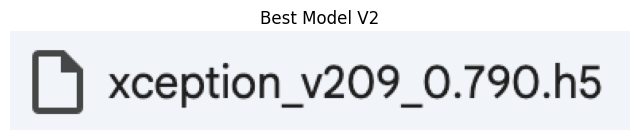

In [45]:
image_path = "./images/best_model_v2.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V2")
plt.show()

## Adding more layers

Let's test to see if adding more dense layers will improve the model performance.

In [46]:
def make_model_more_layers(learning_rate=0.001, size_inner=100):
  base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(10)(inner)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [48]:
learning_rate = 0.001

scores_inner_layer = {}

for size in [10, 100, 1000]:
  print(size)
  model = make_model_more_layers(learning_rate=learning_rate, size_inner=size)
  history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint])
  scores_inner_layer[size]=history.history

  print()
  print()

10
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3877 - loss: 1.7994

75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.3893 - loss: 1.7953 - val_accuracy: 0.6233 - val_loss: 1.1299
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7074 - loss: 0.9666

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7074 - loss: 0.9666 - val_accuracy: 0.6733 - val_loss: 0.9791
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7615 - loss: 0.7809

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7615 - loss: 0.7809 - val_accuracy: 0.6833 - val_loss: 0.9338
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8098 - loss: 0.6537

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8097 - loss: 0.6538 - val_accuracy: 0.6967 - val_loss: 0.8738
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8371 - loss: 0.5528 - val_accuracy: 0.6967 - val_loss: 0.8595
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8416 - loss: 0.4987 - val_accuracy: 0.6867 - val_loss: 0.8807
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8782 - loss: 0.4270

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8781 - loss: 0.4272 - val_accuracy: 0.7100 - val_loss: 0.8431
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8936 - loss: 0.3718 - val_accuracy: 0.7067 - val_loss: 0.8743
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9032 - loss: 0.3431

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9031 - loss: 0.3432 - val_accuracy: 0.7300 - val_loss: 0.8569
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9258 - loss: 0.3125 - val_accuracy: 0.7133 - val_loss: 0.8878
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9357 - loss: 0.2550 - val_accuracy: 0.6900 - val_loss: 0.8776
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9520 - loss: 0.2407 - val_accuracy: 0.7167 - val_loss: 0.8716
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9523 - loss: 0.2200 - val_accuracy: 0.7167 - val_loss: 0.8912
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9688 - loss: 0.1821 - val_accuracy: 0.7167 - val_loss: 0.9070
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9625 - loss: 0.1998 - val_accuracy: 0.7133 - val_loss: 0.9035
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9730 - loss: 0.1613 - val_accuracy: 0.7200 - val_l

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9884 - loss: 0.1103 - val_accuracy: 0.7367 - val_loss: 0.9530


100
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.5408 - loss: 1.3940 - val_accuracy: 0.7367 - val_loss: 0.8009
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8266 - loss: 0.5269

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8265 - loss: 0.5272 - val_accuracy: 0.7567 - val_loss: 0.7959
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8806 - loss: 0.3955

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8806 - loss: 0.3954 - val_accuracy: 0.7667 - val_loss: 0.8140
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9196 - loss: 0.2698 - val_accuracy: 0.7567 - val_loss: 0.8040
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9547 - loss: 0.1805 - val_accuracy: 0.7533 - val_loss: 0.8323
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9840 - loss: 0.1144 - val_accuracy: 0.7333 - val_loss: 0.8926
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9812 - loss: 0.1018

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9812 - loss: 0.1018 - val_accuracy: 0.7767 - val_loss: 0.8734
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9960 - loss: 0.0552 - val_accuracy: 0.7333 - val_loss: 0.9226
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9981 - loss: 0.0428

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9981 - loss: 0.0428 - val_accuracy: 0.7933 - val_loss: 0.9254
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9993 - loss: 0.0291 - val_accuracy: 0.7533 - val_loss: 0.9991
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9999 - loss: 0.0245 - val_accuracy: 0.7667 - val_loss: 0.9608
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 1.0000 - loss: 0.0162 - val_accuracy: 0.7633 - val_loss: 0.9704
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.7667 - val_loss: 1.0077
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.7633 - val_loss: 1.0274
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.7700 - val_loss: 1.0520
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.7667 - val_l

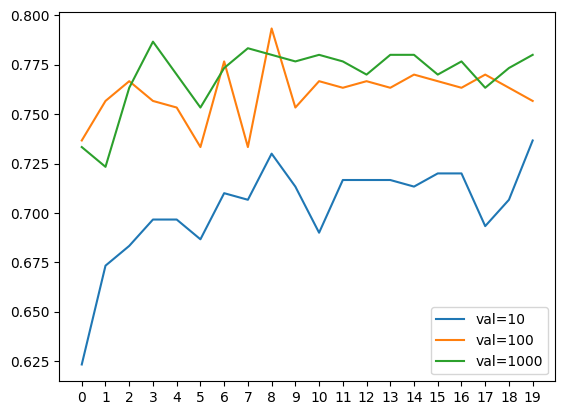

In [53]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  #plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.legend()

The 10 option for the dense layers was consistently underperforming, so we are going to remove it.

In [54]:
del scores_inner_layer[10]

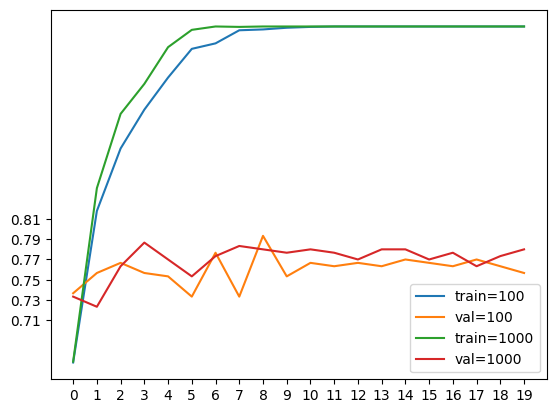

In [59]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for size, hist in scores_inner_layer.items():
  plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(20))
plt.yticks([0.71, 0.73, 0.75, 0.77, 0.79, 0.81])
plt.legend()

I'll choose a 1000 for the inner layer size since it is giving higher validation accuracy majority of the time

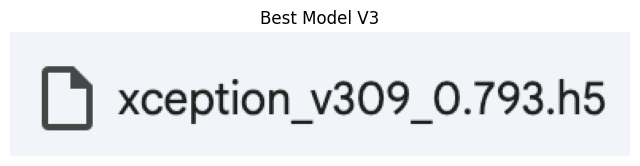

In [50]:
image_path = "./images/best_model_v3.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3")
plt.show()

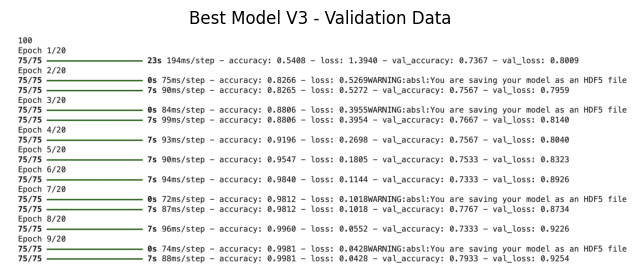

In [51]:
image_path = "./images/best_model_v3_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V3 - Validation Data")
plt.show()

You can see that the 9th epoch is the one that was saved as the best performer. Let's see if regularization and dropout will help with preventing overfitting the model.

## Regularization and Dropout

In [60]:
def make_model_more_layers_and_drop(learning_rate=0.001, size_inner=1000, droprate=0.2):
  base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [61]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [62]:
learning_rate = 0.001
size = 1000
scores_droprate = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
  print(droprate)
  model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
  history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])
  scores_droprate[droprate]=history.history

  print()
  print()

0.0
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5883 - loss: 1.2852

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.5896 - loss: 1.2813 - val_accuracy: 0.7200 - val_loss: 0.7941
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8624 - loss: 0.4435

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8622 - loss: 0.4439 - val_accuracy: 0.7333 - val_loss: 0.8496
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9111 - loss: 0.2575

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9111 - loss: 0.2576 - val_accuracy: 0.7433 - val_loss: 0.8816
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.9527 - loss: 0.1643 - val_accuracy: 0.7300 - val_loss: 0.8874
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9759 - loss: 0.1043

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9760 - loss: 0.1041 - val_accuracy: 0.7467 - val_loss: 1.0203
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9988 - loss: 0.0354

75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9988 - loss: 0.0353 - val_accuracy: 0.7633 - val_loss: 0.9710
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0154

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.7700 - val_loss: 1.0295
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0088

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.7800 - val_loss: 1.0698
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7700 - val_loss: 1.0700
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7700 - val_loss: 1.0844
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.7767 - val_loss: 1.0967
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.7733 - val_loss: 1.1198
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.7767 - val_loss: 1.1225
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7700 - val_loss: 1.1412
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7767 - val_l

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9731 - loss: 0.1096 - val_accuracy: 0.7967 - val_loss: 0.8925
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9894 - loss: 0.0558 - val_accuracy: 0.7867 - val_loss: 0.9789
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9907 - loss: 0.0456 - val_accuracy: 0.7700 - val_loss: 0.9948
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9992 - loss: 0.0212 - val_accuracy: 0.7800 - val_loss: 1.0376
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9981 - loss: 0.0176 - val_accuracy: 0.7633 - val_loss: 1.0460
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9978 - loss: 0.0138 - val_accuracy: 0.7700 - val_loss: 1.0439
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9971 - loss: 0.0150 - val_accuracy: 0.7667 - val_loss: 1.0839
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9982 - loss: 0.0111 - val_accuracy: 0.7967 - val_loss

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8000 - val_loss: 1.1796
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.7900 - val_loss: 1.1931
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.7833 - val_loss: 1.1983
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7767 - val_loss: 1.2198
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7833 - val_loss: 1.2334
Epoch 24/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7833 - val_loss: 1.2342
Epoch 25/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.7833 - val_loss: 1.2334
Epoch 26/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 1.0000 - loss: 8.9869e-04 - val_accuracy: 0.7833 - v

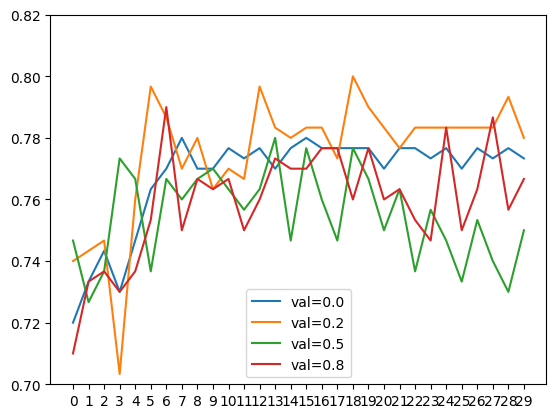

In [66]:
# final plot to see the gaps between the 2 validation and test sets for each learning rate
for droprate, hist in scores_droprate.items():
  #plt.plot(hist['accuracy'], label='train=%s' % droprate)
  plt.plot(hist['val_accuracy'], label='val=%s' % droprate)
plt.xticks(np.arange(30))
plt.ylim(0.70, 0.82)
plt.legend()

Towards the end, the droprates diverge. It kind of looks like 0.0 and 0.2 droprate have the best validation accuracy results.

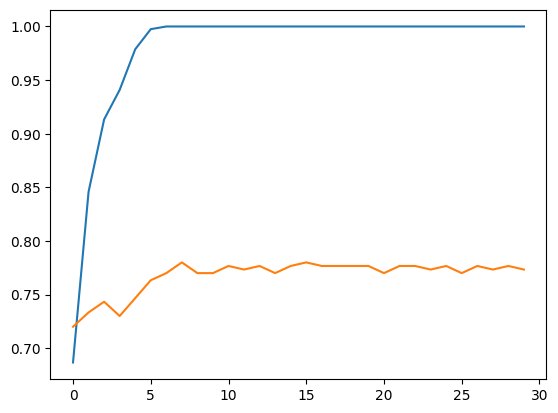

In [67]:
hist = scores_droprate[0.0]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

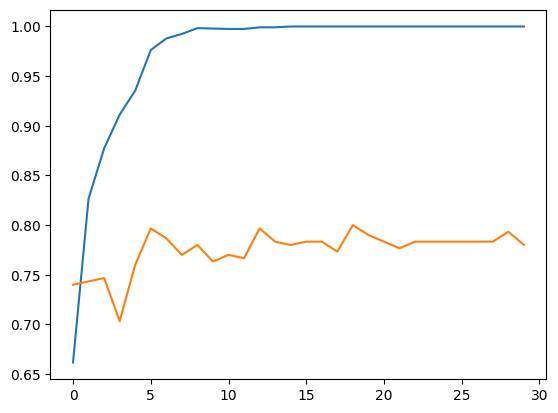

In [68]:
hist = scores_droprate[0.2]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

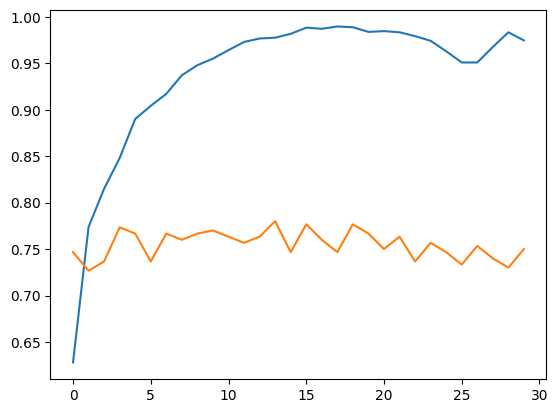

In [69]:
hist = scores_droprate[0.5]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

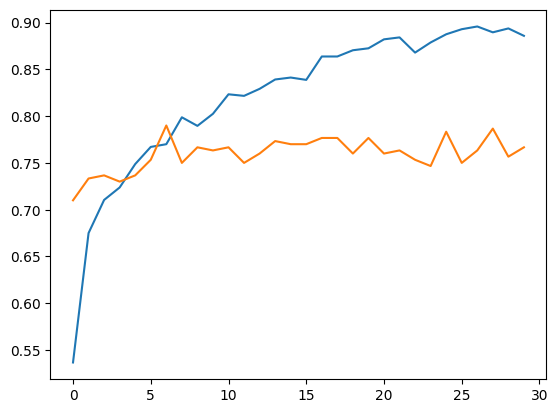

In [70]:
hist = scores_droprate[0.8]
plt.plot(hist['accuracy'], label='train=%s' % droprate)
plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

Conclusion: for 0.8, the validation scores oscillate around 0.75. For 0.5, the validation scores oscillate around 0.735, for 0.2, the validation accuracy scores oscillate around 0.77, and the validation accuracy score for 0.0 oscillate around 0.76. Looks like 0.0 and 0.2 should be inspected further

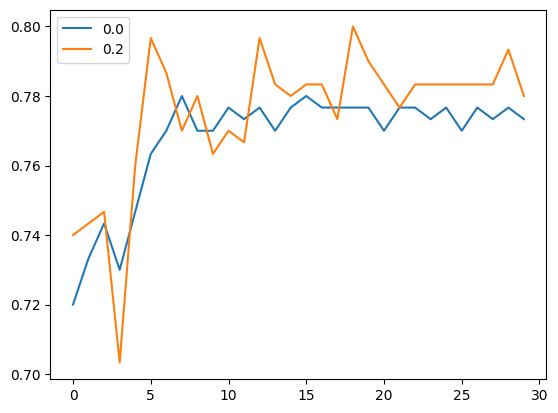

In [71]:
hist = scores_droprate[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores_droprate[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()

Let's use 0.2 to prevent overfitting and yield higher validation accuracy results.

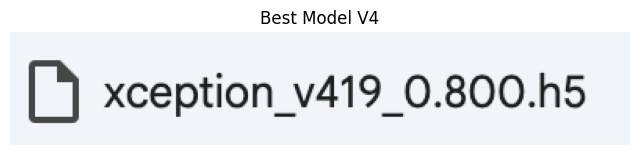

In [73]:
image_path = "./images/best_model_v4.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4")
plt.show()

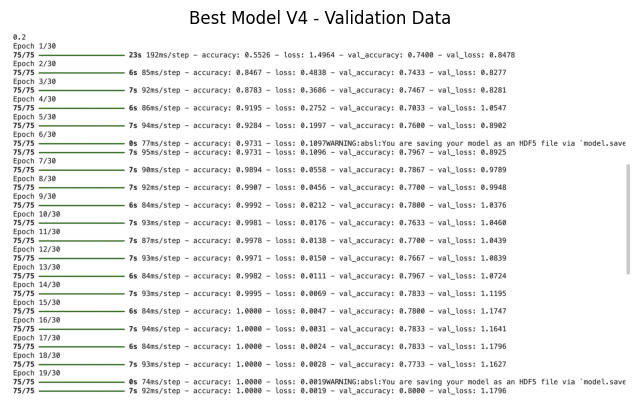

In [74]:
image_path = "./images/best_model_v4_val_data.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V4 - Validation Data")
plt.show()

You can see that the droprate of 0.2 yielded the highest validation accuracy of 0.8 on the 19th epoch.

Let's see if data augmentation can help, too.

## Data Augmentation

In [75]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    vertical_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(150,150),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(150,150),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [76]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v5{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

Let's first re-train the best model with 50 epochs.

In [77]:
learning_rate = 0.001
size = 1000
droprate = 0.2

model = make_model_more_layers_and_drop(learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5210 - loss: 1.4989

75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.5222 - loss: 1.4950 - val_accuracy: 0.7233 - val_loss: 0.9279
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7518 - loss: 0.7236 - val_accuracy: 0.7033 - val_loss: 0.8407
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8000 - loss: 0.6000 - val_accuracy: 0.6967 - val_loss: 0.8797
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8197 - loss: 0.5825 - val_accuracy: 0.6967 - val_loss: 0.9948
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8479 - loss: 0.4667

75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.8478 - loss: 0.4668 - val_accuracy: 0.7467 - val_loss: 0.8649
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8769 - loss: 0.3847 - val_accuracy: 0.7433 - val_loss: 0.8444
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8831 - loss: 0.3506

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8831 - loss: 0.3504 - val_accuracy: 0.7633 - val_loss: 0.9108
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9067 - loss: 0.2626 - val_accuracy: 0.7467 - val_loss: 0.8938
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9329 - loss: 0.1943 - val_accuracy: 0.7633 - val_loss: 0.9304
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9501 - loss: 0.1625 - val_accuracy: 0.7533 - val_loss: 0.9537
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9479 - loss: 0.1751 - val_accuracy: 0.7633 - val_loss: 0.9429
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9591 - loss: 0.1281

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.9591 - loss: 0.1281 - val_accuracy: 0.7700 - val_loss: 0.9508
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9674 - loss: 0.1118 - val_accuracy: 0.7233 - val_loss: 1.1176
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9735 - loss: 0.0933 - val_accuracy: 0.7267 - val_loss: 1.1702
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9827 - loss: 0.0682 - val_accuracy: 0.7367 - val_loss: 1.0330
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9857 - loss: 0.0564 - val_accuracy: 0.7500 - val_loss: 1.1166
Epoch 17/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9757 - loss: 0.0741 - val_accuracy: 0.7433 - val_loss: 1.1681
Epoch 18/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9778 - loss: 0.0620 - val_accuracy: 0.7533 - val_loss: 1.2540
Epoch 19/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9808 - loss: 0.0618 - val_accuracy: 0.7367 - val_l

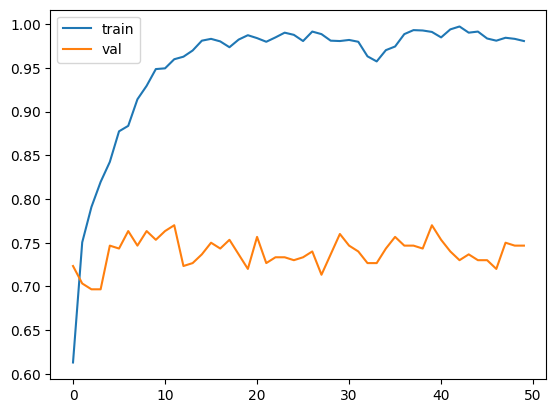

In [78]:
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')
plt.legend()

Conclusion: applying augmentation to smaller models makes the performance worse, so we are not going to use it.

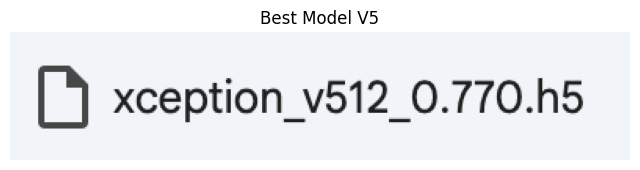

In [89]:
image_path = "./images/best_model_v5.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V5")
plt.show()

## Training a larger model

In [79]:
def make_model_more_layers_and_drop_large(input_size=150,learning_rate=0.001, size_inner=100, droprate=0.2):
  base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size,input_size,3)
)
  # making no changes to the convolutional layers
  base_model.trainable=False

  ################################################
  ## Creating a new top (dense layers)
  inputs = keras.Input(shape=(input_size,input_size,3))
  base = base_model(inputs, training=False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ################################################

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
              )

  return model

In [81]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
    )
train_ds = train_gen.flow_from_directory(
    './food-101/train',
      target_size=(299,299),
      batch_size=32
      )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './food-101/validation',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [82]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v6{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max' # maximize accuracy
    )

In [83]:
learning_rate = 0.0005
size = 1000
droprate = 0.2
input_size=299

model = make_model_more_layers_and_drop_large(input_size=299, learning_rate=learning_rate, size_inner=size, droprate=droprate)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.6696 - loss: 1.1002

75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6711 - loss: 1.0951 - val_accuracy: 0.8633 - val_loss: 0.4637
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 754ms/step - accuracy: 0.8777 - loss: 0.3721 - val_accuracy: 0.8600 - val_loss: 0.4650
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 755ms/step - accuracy: 0.9093 - loss: 0.2795 - val_accuracy: 0.8233 - val_loss: 0.5019
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 759ms/step - accuracy: 0.9090 - loss: 0.2923 - val_accuracy: 0.8600 - val_loss: 0.4672
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.9399 - loss: 0.1955

75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 761ms/step - accuracy: 0.9399 - loss: 0.1954 - val_accuracy: 0.8867 - val_loss: 0.4349
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 763ms/step - accuracy: 0.9433 - loss: 0.1844 - val_accuracy: 0.8667 - val_loss: 0.4154
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 751ms/step - accuracy: 0.9483 - loss: 0.1454 - val_accuracy: 0.8700 - val_loss: 0.4380
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 766ms/step - accuracy: 0.9606 - loss: 0.1206 - val_accuracy: 0.8700 - val_loss: 0.4899
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 748ms/step - accuracy: 0.9640 - loss: 0.1162 - val_accuracy: 0.8800 - val_loss: 0.4354
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 746ms/step - accuracy: 0.9777 - loss: 0.0771 - val_accuracy: 0.8567 - val_loss: 0.5441
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 759ms/step - accuracy: 0.9794 - loss: 0.0754 - val_accuracy: 0.8633 - val_loss: 0.4795
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 748ms/step - accuracy: 0.9788 - loss: 0.0750 - val_accuracy: 0.

KeyboardInterrupt: 

I've interrupted the code for training to not run out of the TPU resources I have been provided by Google Colab.

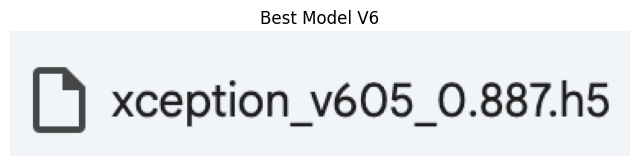

In [84]:
image_path = "./images/best_model_v6.png"  # adjust path as needed
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

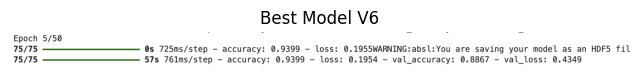

In [87]:
image_path = "./images/best_model_v6_val_data.png"
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Best Model V6")
plt.show()

We can see that on the 5th epoch for the larger model the highest accuracy has been yielded of 0.887. I did not run all 50 epochs of training since I did not want to run out of TPU.

## Using the model

In [90]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.utils import load_img

In [91]:
model = keras.models.load_model('xception_v605_0.887.h5')

In [93]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    './food-101/test',
      target_size=(299,299),
      batch_size=32,
      shuffle=False
      )

Found 300 images belonging to 10 classes.


In [94]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8928 - loss: 0.4256


[0.36581480503082275, 0.9100000262260437]

The test accuracy of the data is 0.892, which is not far off from 0.887 of the validation data. This means that the model did not overfit, which is a great thing!

## Applying the model to the image

In [100]:
path = './food-101/test/hamburger/170292.jpg'

In [101]:
img = load_img(path, target_size=(299,299))

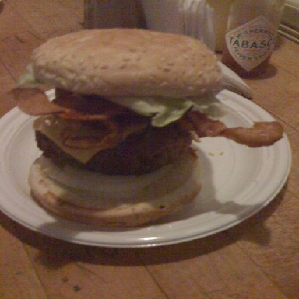

In [102]:
img

In [103]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


In [105]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

In [106]:
prediction = dict(zip(classes,pred[0]))

In [107]:
prediction

{'chicken_curry': np.float32(-2.0170941),
 'chocolate_cake': np.float32(-0.28468657),
 'fish_and_chips': np.float32(-0.049484104),
 'hamburger': np.float32(12.348978),
 'ice_cream': np.float32(0.83554983),
 'pad_thai': np.float32(-3.073039),
 'pizza': np.float32(-0.82561415),
 'ramen': np.float32(-5.021347),
 'sushi': np.float32(-1.7653358),
 'tacos': np.float32(-0.8785776)}

So, it looks like the model output hamburger as our prediction, which is right :)

## Export the model to ONNX

In [108]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 126.7 MB/s eta 0:00:00


In [109]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: onnx
    Found existing installation: onnx 1.20.0
    Uninstalling onnx-1.20.0:
      Successfully uninstalled onnx-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires

In [1]:
# Export to ONNX
onnx_path = "food_classifier_xception_v6.onnx"

import tensorflow as tf
from tensorflow import keras
import tf2onnx
import tf2onnx.convert
import onnx

In [2]:
# 1. Load your Keras model (e.g., from an H5 file)
keras_model = keras.models.load_model('xception_v605_0.887.h5')


In [3]:
# 2. Define input signature - corrected version
input_signature = [tf.TensorSpec(keras_model.input[0].shape, keras_model.input[0].dtype, name="input")]

# 3. Convert to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(keras_model,
                                         input_signature=input_signature,  # Use the variable, not the shape
                                  )

# 4. Save the ONNX model
onnx.save(onnx_model, onnx_path)

print(f"Model converted and saved to {onnx_path}")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c70f3cd5300>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


Model converted and saved to food_classifier_xception_v6.onnx


## Testing the ONNX model

In [4]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00


In [5]:
import onnxruntime as ort
import numpy as np
import cv2
from tensorflow.keras.applications.xception import preprocess_input

In [6]:
# 1. Load the ONNX model
onnx_session = ort.InferenceSession(onnx_path)

# 2. Check model info
print("ONNX model loaded successfully!")
print(f"Input name: {onnx_session.get_inputs()[0].name}")
print(f"Input shape: {onnx_session.get_inputs()[0].shape}")
print(f"Output name: {onnx_session.get_outputs()[0].name}")
print(f"Output shape: {onnx_session.get_outputs()[0].shape}")

ONNX model loaded successfully!
Input name: input
Input shape: ['unk__628', 299, 299, 3]
Output name: dense_23
Output shape: ['unk__629', 10]


In [7]:
# 3. Prepare test data (same preprocessing as your training)
def prepare_image(image_path):
    # Load and resize image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))

    # Preprocess (same as training)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)

    return img.astype(np.float32)

In [8]:
# 4. Test with an image
test_image_path = "./food-101/test/hamburger/170292.jpg"  # Replace with actual path
input_data = prepare_image(test_image_path)

# 5. Run inference
input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

onnx_outputs = onnx_session.run([output_name], {input_name: input_data})
onnx_prediction = onnx_outputs[0]

print(f"ONNX prediction shape: {onnx_prediction.shape}")
print(f"ONNX prediction: {onnx_prediction}")



ONNX prediction shape: (1, 10)
ONNX prediction: [[-2.085494   -0.2170257  -0.04230954 12.484779    0.9243137  -3.0904202
  -0.96894425 -5.0462976  -1.7828909  -0.8649304 ]]


In [11]:
classes = ['chicken_curry',
 'chocolate_cake',
 'fish_and_chips',
 'hamburger',
 'ice_cream',
 'pad_thai',
 'pizza',
 'ramen',
 'sushi',
 'tacos']

# Also, you need to flatten the ONNX prediction array
prediction_onnx = dict(zip(classes, onnx_prediction[0]))  # Note the [0] to get the first (and only) sample

In [12]:
prediction_onnx

{'chicken_curry': np.float32(-2.085494),
 'chocolate_cake': np.float32(-0.2170257),
 'fish_and_chips': np.float32(-0.042309538),
 'hamburger': np.float32(12.484779),
 'ice_cream': np.float32(0.9243137),
 'pad_thai': np.float32(-3.0904202),
 'pizza': np.float32(-0.96894425),
 'ramen': np.float32(-5.0462976),
 'sushi': np.float32(-1.7828909),
 'tacos': np.float32(-0.8649304)}

In [13]:
# 6. Compare with original Keras model (optional)
keras_prediction = keras_model.predict(input_data)
print(f"Keras prediction: {keras_prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Keras prediction: [[-2.085494   -0.21702622 -0.04231235 12.48478     0.92431474 -3.0904207
  -0.96894246 -5.0462976  -1.7828904  -0.8649323 ]]


In [14]:
# Flatten the ONNX prediction array
prediction_keras = dict(zip(classes, keras_prediction[0]))

In [15]:
prediction_keras

{'chicken_curry': np.float32(-2.085494),
 'chocolate_cake': np.float32(-0.21702622),
 'fish_and_chips': np.float32(-0.042312354),
 'hamburger': np.float32(12.48478),
 'ice_cream': np.float32(0.92431474),
 'pad_thai': np.float32(-3.0904207),
 'pizza': np.float32(-0.96894246),
 'ramen': np.float32(-5.0462976),
 'sushi': np.float32(-1.7828904),
 'tacos': np.float32(-0.8649323)}

In [16]:
# check if predicitons are close
max_value_keras = max(prediction_keras.values())
max_value_onnx = max(prediction_onnx.values())
print(f"Max value keras: {max_value_keras}")
print(f"Max value onnx: {max_value_onnx}")

Max value keras: 12.484780311584473
Max value onnx: 12.484779357910156


In [17]:

# Check if predictions are close
diff = np.abs(max_value_onnx - max_value_keras)
print(f"Max difference: {np.max(diff)}")
print(f"Are predictions close? {np.allclose(max_value_onnx, max_value_keras, atol=1e-5)}")

Max difference: 9.5367431640625e-07
Are predictions close? True


Looks like the scores for the 2 models are not significantly different. both of the models output hamburger as a final prediction, which is correct and cool. We are going to use ONNX model for the training and predicting the food.